## Summary

- Create sequence alignment plots of designs vs. reference proteins.
- Find the closest homologs of design sequences in the training dataset.

----

## Imports

In [40]:
import contextlib
import gzip
import shlex
import subprocess
import tempfile
from pathlib import Path
from typing import NamedTuple

import biotite
import biotite.sequence.align
import biotite.sequence.graphics
import matplotlib.pyplot as plt
import mdtraj
import numpy as np
import pandas as pd
import proteinsolver
import pyarrow as pa
import pyarrow.parquet as pq
from IPython.display import HTML, SVG, set_matplotlib_formats
from kmbio import PDB
from kmtools import structure_tools
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from tqdm.notebook import tqdm

In [41]:
set_matplotlib_formats("svg")

# Parameters

In [42]:
NOTEBOOK_NAME = "07_protein_analysis_experimental"
NOTEBOOK_PATH = Path(NOTEBOOK_NAME)
NOTEBOOK_PATH.mkdir(exist_ok=True)
NOTEBOOK_PATH

PosixPath('07_protein_analysis_experimental')

In [43]:
UNIQUE_ID = "191f05de"  # No attention
# UNIQUE_ID = "0007604c"  # 5-layer graph-conv with attention, batch_size=1
# UNIQUE_ID = "91fc9ab9"  # 4-layer graph-conv with attention, batch_size=4

In [44]:
BEST_STATE_FILES = {
    #
    "191f05de": "protein_train/191f05de/e53-s1952148-d93703104.state"
}

In [45]:
DATAPKG_DATA_DIR = Path(f"~/datapkg_data_dir").expanduser().resolve()
DATAPKG_DATA_DIR

PosixPath('/home/strokach/datapkg_data_dir')

## Designs

In [46]:
designs = [
    # First batch
    (
        "1n5u_DopeNormalized.pdb",
        "1n5uA03",
        "DopeNormalized",
        10,
        "GSGTEEFLKFAKERLSRRFPEASEEEVERLTEIETKVKECCRAGDEKTCKECRSNLASYVCSNRDLLSDDLKECCEKPTSDISSCLSNVTKN",
    ),
    (
        "4beu_DopeHD.pdb",
        "4beuA02",
        "DopeHD",
        7,
        "MEAFRAALEAFRAALDAGVRLAALLRRAARARGLRALVPELLARGLPAVGVDSLAEARAVREAGFRGDVLFVRSATLEEIAAALATGLAVVVGSDEQAAALAALAAEAGRALAVELGLSVAGPARDGLDLSTAEGVARAAALARVAGLAVRGILDHLPDEDAERVRARLEAFRAAAALLLEAAGLPRDGLAVHVGDSRAARALPEARPDLVYVGAEL",
    ),
    (
        "4unu_Rosetta.pdb",
        "4unuA00",
        "Rosetta",
        0,
        "MAFTHPAAATATPGGTVRVACTGDKETVADRPDITWHLRRAGRAVVPVVTGTGALPAGVSPRLTGSEGGNVATLDVEGVTAEDAGVYYCSTRLTDGDVLEGPGTRVTVG",
    ),
    (
        "4z8j_DopeHD.pdb",
        "4z8jA00",
        "DopeHD",
        0,
        "MPYKVTFEKADDGFGFDVVGFAEKGGEKVDIKGEKWEPVVTVTSVKPGGAAEKAGIKEGEIIRKVKGSEVIGASFEEVVALLESGDGVIELDVIDV",
    ),
    (
        "4beu_Comments.pdb",
        "4beuA02",
        "Comments",
        4,
        "MEAFRAALEAFRAALDAEVRLAALLRRAARARGLRALVPELLARGLPAVGVDSLAEARAVREAGFRGDVLFHRSATLEEIAAALATGLAVVVGSDEQAAALAALAAEAGRALRVELGLSVAGPARDGLDLDTAEGRARAAALARVAGLEVRGILDHLPDEDAERVRARLERFRAAAALLLEAAGLPRDGLAVHVGDSRAARALPEARPDLVYVGDEL",
    ),
    (
        "4unu_Comments.pdb",
        "4unuA00",
        "Comments",
        0,
        "AAFTHPATATATPGGTVRVACTGDRETVADRPDITWHLRRAGRAVTPVVEGTGALPAGVSPRLTGSEGGNVATLDVEGVTAEDAGVYYCSTRLTDGDVLEGPGTRVTVG",
    ),
    (
        "4z8j_Comments.pdb",
        "4z8jA00",
        "Comments",
        4,
        "MPYKVTFEKADDGFGFDVVGFAEKGGEKVDIKGKKWEPVVTVKSVKPGGAAEKAGIKEGEIIRKVKGSEVRGASFEEVVALLESGDGVIELDVIDV",
    ),
    (
        "4unu_FilteredRosetta.pdb",
        "4unuA00",
        "FilteredRosetta",
        0,
        "SAFTHPAAATARPGGTVRVACTGDKETVADRPDITWHLRRAGRAVTPVVEGTGALPAGVSPRLTGSEGGNVATLDVEGVTAEDAGVYYCSTRLDDGDVLEGPGTRVTVG",
    ),
    (
        "4unu_FilteredMolPDF3.pdb",
        "4unuA00",
        "FilteredMolPDF3",
        0,
        "MPFTHPASATARPGGTVRVACRGDRETVADRPDITWHLRRAGRAVTPVVEGTGALPAGVSPRLTGSEGGNVATLDVEGVTAEDAGVYYCSTRLTDGDVLEGPGTRVTVG",
    ),
    (
        "4z8j_FilteredDopeNormalized.pdb",
        "4z8jA00",
        "FilteredDopeNormalized",
        0,
        "MPYKVTFEKTDDGFGFDVVGFKEKGGEKVDIKGKKWEPVVTVKSVKPGGAAEKAGIKEGEIIRKVKGSEVRGASFEEVVALLESGDGVIELDVIDV",
    ),
    (
        "4z8j_FilteredDopeHR2.pdb",
        "4z8jA00",
        "FilteredDopeHR2",
        0,
        "MPYKVTFEKTDDGFGFDVVGFKEKGGAKVDIKGKKWEPVVAVTSVKPGGAAEKAGIKEGEIIRKVKGSEVRGASFEEVVALLESGDGVIELDVIDV",
    ),
]

In [47]:
designs_df = pd.DataFrame(designs, columns=["filename", "domain_id", "selection_method", "score", "sequence"]).sort_values("domain_id")

In [48]:
designs_df

,filename,domain_id,selection_method,score,sequence
0,1n5u_DopeNormalized.pdb,1n5uA03,DopeNormalized,10,GSGTEEFLKFAKERLSRRFPEASEEEVERLTEIETKVKECCRAGDE...
1,4beu_DopeHD.pdb,4beuA02,DopeHD,7,MEAFRAALEAFRAALDAGVRLAALLRRAARARGLRALVPELLARGL...
4,4beu_Comments.pdb,4beuA02,Comments,4,MEAFRAALEAFRAALDAEVRLAALLRRAARARGLRALVPELLARGL...
2,4unu_Rosetta.pdb,4unuA00,Rosetta,0,MAFTHPAAATATPGGTVRVACTGDKETVADRPDITWHLRRAGRAVV...
5,4unu_Comments.pdb,4unuA00,Comments,0,AAFTHPATATATPGGTVRVACTGDRETVADRPDITWHLRRAGRAVT...
7,4unu_FilteredRosetta.pdb,4unuA00,FilteredRosetta,0,SAFTHPAAATARPGGTVRVACTGDKETVADRPDITWHLRRAGRAVT...
8,4unu_FilteredMolPDF3.pdb,4unuA00,FilteredMolPDF3,0,MPFTHPASATARPGGTVRVACRGDRETVADRPDITWHLRRAGRAVT...
3,4z8j_DopeHD.pdb,4z8jA00,DopeHD,0,MPYKVTFEKADDGFGFDVVGFAEKGGEKVDIKGEKWEPVVTVTSVK...
6,4z8j_Comments.pdb,4z8jA00,Comments,4,MPYKVTFEKADDGFGFDVVGFAEKGGEKVDIKGKKWEPVVTVKSVK...
9,4z8j_FilteredDopeNormalized.pdb,4z8jA00,FilteredDopeNormalized,0,MPYKVTFEKTDDGFGFDVVGFKEKGGEKVDIKGKKWEPVVTVKSVK...


In [49]:
(np.array(list("GSGTEEFLKFAKERLSRRFPEASEEEVERLTEIETKVKECCRAGDEKTCKECRSNLASYVCSNRDLLSDDLKECCEKPTSDISSCLSNVTKN")) == "C").sum()

8

In [53]:
(np.array(list(domain_id_to_sequence["1n5uA03"])) == "C").sum()

7

In [106]:
ls /home/kimlab1/strokach/datapkg_data_dir/deep-protein-gen/

blastdb/           training_data_rs0.parquet  training_data_rs5.parquet
datasets-test/     training_data_rs1.parquet  training_data_rs6.parquet
processed/         training_data_rs2.parquet  training_data_rs7.parquet
sudoku/            training_data_rs3.parquet  training_data_rs8.parquet
sudoku_difficult/  training_data_rs4.parquet  training_data_rs9.parquet


In [113]:
ls /home/kimlab1/strokach/datapkg_data_dir/deep-protein-gen/processed/

test_data/  training_data_0/  training_data_1/  validation_data/


In [61]:
reader = pq.ParquetFile("/home/kimlab1/strokach/datapkg_data_dir/deep-protein-gen/training_data_rs0.parquet")

In [70]:
cath_ids = set()

for rs in range(10):
    reader = pq.ParquetFile(
        f"/home/kimlab1/strokach/datapkg_data_dir/deep-protein-gen/training_data_rs{rs}.parquet"
    )
    for row_group_idx in range(reader.num_row_groups):
        df = reader.read_row_group(row_group_idx, columns=["database_id"]).to_pandas()
        cath_ids |= set(df["database_id"])

In [115]:
len(cath_ids)

998

In [116]:
sequences = set()

for rs in range(10):
    reader = pq.ParquetFile(
        f"/home/kimlab1/strokach/datapkg_data_dir/deep-protein-gen/training_data_rs{rs}.parquet"
    )
    for row_group_idx in range(reader.num_row_groups):
        df = reader.read_row_group(row_group_idx, columns=["sequence"]).to_pandas()
        sequences |= set(df["sequence"])

In [121]:
sequences.pop()

'MYGPADRAGDPPPPGTYPFTRGNFASGYRGKTWTFRQYSGFGTAEESNRRYRYLLDQGGTGLSVALDLPTQCGYDSDDPEFGEEVGRVGVAVDTLADAEILFDGIPLDKISTSFTINGTAAILLAFYVAAAEKKGVPREKLTGTIQNDILKEYASRGTWIWPPEPSLRLIADTIEFCAAEVPRFNAISVAGAHFRDAGANAVQEMAFTLADGVTYCDTVVERGRMTIDKFAPQISFFFYTHGDFFEEIAKYRAGRRRWATIVRERYGATTDKASMFRFGCVAGGASLYAPQAQNNLVRVAYEAMAAVLGGVQSMFTAAWDEPFALPSEESATLALRTQQILAYETGVTKVADPLGGSYFVEALTDATEAKIVEIMHDLETHGGMVRCIEDGYLQGLIADEAFKIHQDVESGERPVVGVNRFVTDEPPPEIATYELDAEGRDVQLKRLAKVKADRDGLAVKEALAALSEAAEGQENLMHKLIDCANAYCTVGEMVSTLKSVWGEF'

In [103]:
structure_ids = set()

for rs in range(10):
    reader = pq.ParquetFile(
        f"/home/kimlab1/strokach/datapkg_data_dir/deep-protein-gen/training_data_rs{rs}.parquet"
    )
    for row_group_idx in range(reader.num_row_groups):
        df = reader.read_row_group(row_group_idx, columns=["structure_id"]).to_pandas()
        structure_ids |= set(df["structure_id"])

In [118]:
len({s.lower() for s in structure_ids})

87043

In [101]:
df = reader.read_row_group(row_group_idx).to_pandas()

In [102]:
df.head()

,uniparc_id,structure_id,sequence,residue_idx_1_corrected,residue_idx_2_corrected,distances,database_id
0,UPI0001A5493C,2D0P,LGLGVGVTITIDELVTRDPTRPYILVVPSAVDFADVAAVVNAAHGA...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 2, 3, 4, 21, 22, 48, 49, 50, 51, 52, 58, 6...","[1.3307537270409626, 4.125300748036694, 7.6290...",3.50.30.70
1,UPI0006513B78,1MRQ,KYECMELNDGHFIPILGFGTYAPNEVPKSQATEATKLAIDAGFRHI...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 2, 3, 4, 11, 12, 13, 14, 15, 16, 17, 35, 3...","[1.330960242524756, 3.3503904499151735, 6.6098...",3.20.20.100
2,UPI00001277E2,5B5I,FDPSCTGVFDRQLLRRLRRVCDDCFNVFREPNVSTECRSNCYNNEV...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 39, 40, 2,...","[1.3341928645885017, 3.2028277164627386, 5.948...",1.10.2010.10
3,UPI000428EA3D,2HIV,MTLPYADLVAASHAVAATRSRTAKTTLLAEVLRRADPEEVGVVAAH...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 27, 2, 3, 4, 5, 6,...","[1.3351871849706525, 3.2427762206468587, 3.209...",1.10.3260.10
4,UPI000A291442,2JZ5,GEIGFIIKEGDDVAEVTVYGNSKALIETEFAKYVELAKQVSSNVEF...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 60, 2, 3, 4, 5...","[1.321107118872453, 2.889212456005413, 7.32042...",3.30.70.860


In [95]:
cath_topologies = {".".join(c.split(".")[:3]) for c in cath_ids}

In [96]:
"1.10.246.10" in cath_ids
"1.10.246" in cath_topologies

False

In [97]:
"2.30.42.10" in cath_ids
"2.30.42" in cath_topologies

False

In [98]:
"2.60.40.10" in cath_ids
"2.60.40" in cath_topologies

True

In [99]:
"3.20.20.10" in cath_ids
"3.20.20" in cath_topologies

True

In [100]:
[c for c in cath_ids if ""]

[]

## Reference structures

In [50]:
def to_mdtraj(structure):
    import mdtraj
    with tempfile.NamedTemporaryFile(suffix=".pdb") as tmp:
        PDB.save(structure, tmp.name)
        traj = mdtraj.load(tmp.name)
    return traj

In [51]:
domain_id_to_structure = {}
domain_id_to_sequence = {}
domain_id_to_sasa = {}
domain_id_to_dssp = {}

for file in Path(proteinsolver.__path__[0]).joinpath("data", "inputs").glob("*.pdb"):
    print(file)
    structure = PDB.load(file)
    traj = to_mdtraj(structure)
    
    sequence = structure_tools.extract_aa_sequence(structure, 0, list(structure[0])[0].id)
    sasa = structure_tools.protein_structure_analysis.calculate_sasa(traj)
    assert len(sasa) == len(sequence)
    dssp = mdtraj.compute_dssp(traj).squeeze()
    assert len(dssp) == len(sequence)
    domain_id_to_structure[file.stem] = structure
    domain_id_to_sequence[file.stem] = sequence
    domain_id_to_sasa[file.stem] = sasa
    domain_id_to_dssp[file.stem] = dssp

domain_id_to_structure, domain_id_to_sequence

/home/kimlab1/strokach/workspace/proteinsolver/proteinsolver/data/inputs/1n5uA03.pdb
/home/kimlab1/strokach/workspace/proteinsolver/proteinsolver/data/inputs/4beuA02.pdb
/home/kimlab1/strokach/workspace/proteinsolver/proteinsolver/data/inputs/4unuA00.pdb
/home/kimlab1/strokach/workspace/proteinsolver/proteinsolver/data/inputs/4z8jA00.pdb
/home/kimlab1/strokach/workspace/proteinsolver/proteinsolver/data/inputs/5vli02.pdb
/home/kimlab1/strokach/workspace/proteinsolver/proteinsolver/data/inputs/3fndA02.pdb


({'1n5uA03': <Structure id=1n5ua03>,
  '4beuA02': <Structure id=4beua02>,
  '4unuA00': <Structure id=4unua00>,
  '4z8jA00': <Structure id=4z8ja00>,
  '5vli02': <Structure id=5vli02>,
  '3fndA02': <Structure id=3fnda02>},
 {'1n5uA03': 'KFGERAFKAWAVARLSQRFPKAEFAEVSKLVTDLTKVHTECCHGDLLECADDRADLAKYICENQDSISSKLKECCEKPLLEKSHCIAEVEND',
  '4beuA02': 'LGQFQSNIEQFKSHMNANTKICAIMKADAYGNGIRGLMPTIIAQGIPCVGVASNAEARAVRESGFKGELIRVRSASLSEMSSALDLNIEELIGTHQQALDLAELAKQSGKTLKVHIALNDGGMGRNGIDMTTEAGKKEAVSIATQPSLSVVGIMTHFPNYNADEVRAKLAQFKESSTWLMQQANLKREEITLHVANSYTALNVPEAQLDMVRPGGVL',
  '4unuA00': 'SALTQPPSASGSLGQSVTISCTGTSSDVGGYNYVSWYQQHAGKAPKVIIYEVNKRPSGVPDRFSGSKSGNTASLTVSGLQAEDEADYYCSSYEGSDNFVFGTGTKVTVL',
  '4z8jA00': 'SPRVVRIVKSESGYGFNVRGQVSEGGQLRSINGELYAPLQHVSAVLPGGAADRAGVRKGDRILEVNGVNVEGATHKQVVDLIRAGEKELILTVLSV',
  '5vli02': 'CIEQSFTTLFACQTAAEIWRAFGYTVKIMVDGNCRLHVC',
  '3fndA02': 'FYGYSWEESLQGAVDDVRGIRYSGILKHLGNEAADKDNIGKTYY'})

## Workspace

### Sequence alignment plots

In [12]:
def secondary_structure_to_annotation(sse, first_id=0):
    def _add_sec_str(annotation, first, last, str_type):
        if str_type == "H":
            str_type = "helix"
        elif str_type == "E":
            str_type = "sheet"
        elif str_type == "C":
            return
        else:
            raise Exception(f"Unrecognized str_type: {str_type}")
        feature = biotite.sequence.Feature("SecStr", [biotite.sequence.Location(first, last)], {"sec_str_type": str_type})
        annotation.add_feature(feature)

    # Find the intervals for each secondary structure element
    # and add to annotation
    annotation = biotite.sequence.Annotation()
    curr_sse = None
    curr_start = None
    for i in range(len(sse)):
        if curr_start is None:
            curr_start = i
            curr_sse = sse[i]
        else:
            if sse[i] != sse[i - 1]:
                _add_sec_str(annotation, curr_start + first_id, i - 1 + first_id, curr_sse)
                curr_start = i
                curr_sse = sse[i]
    # Add last secondary structure element to annotation
    _add_sec_str(annotation, curr_start + first_id, i - 1 + first_id, curr_sse)

    return annotation

In [13]:
class HelixPlotter(biotite.sequence.graphics.FeaturePlotter):
    def __init__(self):
        pass

    # Check whether this class is applicable for drawing a feature
    def matches(self, feature):
        if feature.key == "SecStr":
            if "sec_str_type" in feature.qual:
                if feature.qual["sec_str_type"] == "helix":
                    return True
        return False

    # The drawing function itself
    def draw(self, axes, feature, bbox, loc, style_param):
        # Approx. 1 turn per 3.6 residues to resemble natural helix
        n_turns = np.ceil((loc.last - loc.first + 1) / 3.6)
        x_val = np.linspace(0, n_turns * 2 * np.pi, 100)
        # Curve ranges from 0.3 to 0.7
        y_val = (-0.4 * np.sin(x_val) + 1) / 2

        # Transform values for correct location in feature map
        x_val *= bbox.width / (n_turns * 2 * np.pi)
        x_val += bbox.x0
        y_val *= bbox.height
        y_val += bbox.y0

        # Draw white background to overlay the guiding line
        background = Rectangle(bbox.p0, bbox.width, bbox.height, color="white", linewidth=0)
        axes.add_patch(background)
        axes.plot(x_val, y_val, linewidth=2, color=biotite.colors["dimgreen"])


class SheetPlotter(biotite.sequence.graphics.FeaturePlotter):
    def __init__(self, head_width=0.8, tail_width=0.5):
        self._head_width = head_width
        self._tail_width = tail_width

    def matches(self, feature):
        if feature.key == "SecStr":
            if "sec_str_type" in feature.qual:
                if feature.qual["sec_str_type"] == "sheet":
                    return True
        return False

    def draw(self, axes, feature, bbox, loc, style_param):
        x = bbox.x0
        y = bbox.y0 + bbox.height / 2
        dx = bbox.width
        dy = 0

        if loc.defect & biotite.sequence.Location.Defect.MISS_RIGHT:
            # If the feature extends into the prevoius or next line
            # do not draw an arrow head
            draw_head = False
        else:
            draw_head = True

        axes.add_patch(
            biotite.AdaptiveFancyArrow(
                x,
                y,
                dx,
                dy,
                self._tail_width * bbox.height,
                self._head_width * bbox.height,
                # Create head with 90 degrees tip
                # -> head width/length ratio = 1/2
                head_ratio=0.5,
                draw_head=draw_head,
                color=biotite.colors["orange"],
                linewidth=0,
            )
        )

In [14]:
class PlotData(NamedTuple):
    first_id: int
    segment_length: int
    sasa: np.ndarray
    sse_annotation: biotite.sequence.annotation.Annotation
    alignment: biotite.sequence.align.Alignment


def get_plot_properties(domain_id, design_id, symbols_per_line=60):
    sequence_ref = domain_id_to_sequence[domain_id]
    sequence_design = designs_df.set_index("filename").at[f"{design_id}.pdb", "sequence"]
    sse = domain_id_to_dssp[domain_id]
    sasa = domain_id_to_sasa[domain_id][:, 1]
    assert len(sequence_ref) == len(sequence_design) == len(sse) == len(sasa)

    for first_id in range(0, len(sequence_ref), symbols_per_line):
        segment = slice(first_id, first_id + symbols_per_line)
        sequence_ref_slice = sequence_ref[segment]
        sequence_design_slice = sequence_design[segment]
        yield PlotData(
            first_id=first_id,
            segment_length=len(sequence_ref_slice),
            sasa=sasa[segment],
            sse_annotation=secondary_structure_to_annotation(sse[segment], first_id),
            alignment=biotite.sequence.align.Alignment(
                [
                    biotite.sequence.ProteinSequence(sequence_ref_slice),
                    biotite.sequence.ProteinSequence(sequence_design_slice),
                ],
                trace=np.arange(len(sequence_ref_slice)).reshape(-1, 1).repeat(2, 1),
            ),
        )

In [35]:
def hide_yaxis_ticks(ax):
    for tic in ax.yaxis.get_major_ticks():
        tic.tick1line.set_visible(False)
        tic.tick2line.set_visible(False)


def create_sequence_alignment_plot(plot_properties, symbols_per_line):
    height_ratios = [3, 3, 3, 1.5] + [1, 3, 3, 3, 1.5] * (len(plot_properties) - 1)
    fg, axs = plt.subplots(
        len(height_ratios),
        1,
        figsize=(10, sum(height_ratios) / 5),
        gridspec_kw={"height_ratios": height_ratios},
    )
    fg.subplots_adjust(left=0.09, bottom=0, top=0.98, right=0.99, hspace=0.1)
    for ax_idx in list(range(3, len(height_ratios), 5)) + list(range(4, len(height_ratios), 5)):
        axs[ax_idx].axis("off")

    for chunk_idx, props in enumerate(plot_properties):
        ax = axs[0 + 5 * chunk_idx]
        x = np.arange(props.segment_length) + 0.5
        ax.plot(x, props.sasa)
        for spine in ["top", "right", "bottom", "left"]:
            ax.spines[spine].set_visible(False)
        ax.set_xlim(0, symbols_per_line)
        ax.set_xticks([])
        ax.set_yticks([0.0, 0.5, 1.0])
        ax.hlines([0.0, 0.5, 1.0], 0, props.segment_length, linestyle=(0, (2, 10)), linewidth=0.5)
        hide_yaxis_ticks(ax)
        ax.set_ylabel("rSASA")

        ax = axs[1 + 5 * chunk_idx]
        biotite.sequence.graphics.plot_feature_map(
            ax,
            props.sse_annotation,
            symbols_per_line=symbols_per_line,
            loc_range=(props.first_id, props.first_id + props.segment_length),
            show_numbers=False,
            show_line_position=False,
            feature_plotters=[HelixPlotter(), SheetPlotter()],
        )
        ax.yaxis.tick_left()
        ax.set_yticks([0.5])
        hide_yaxis_ticks(ax)
        ax.set_yticklabels(["Secondary\nstructure"])

        ax = axs[2 + 5 * chunk_idx]
        biotite.sequence.graphics.plot_alignment_similarity_based(
            ax,
            props.alignment,
            matrix=biotite.sequence.align.SubstitutionMatrix.std_protein_matrix(),
            show_numbers=False,
            show_line_position=True,
            symbols_per_line=symbols_per_line,
        )
        ax.set_yticks([0.5, 1.5])
        ax.set_yticklabels(["Reference", "Design"])
        ax.set_xticks(np.arange(0, props.segment_length, 5) + 0.5)
        ax.set_xticklabels(np.arange(props.first_id, props.first_id + props.segment_length, 5))
    return fg, axs

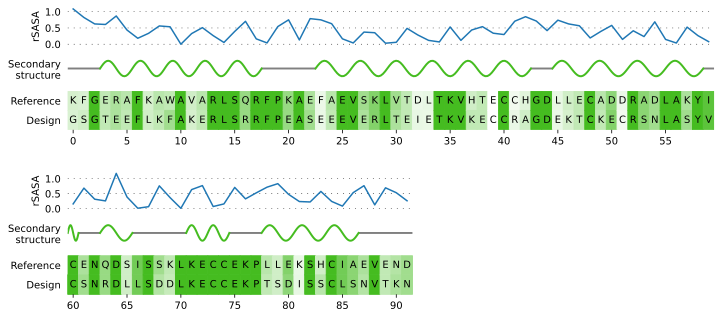

In [36]:
domain_id = "1n5uA03"
design_id = "1n5u_DopeNormalized"
symbols_per_line = 60

plot_properties = list(get_plot_properties(domain_id, design_id, symbols_per_line=symbols_per_line))
fg, axs = create_sequence_alignment_plot(plot_properties, symbols_per_line)

fg.savefig(NOTEBOOK_PATH.joinpath(f"pairwise-alignment-wprops-{domain_id}.svg"))
fg.savefig(NOTEBOOK_PATH.joinpath(f"pairwise-alignment-wprops-{domain_id}.pdf"))
fg.savefig(NOTEBOOK_PATH.joinpath(f"pairwise-alignment-wprops-{domain_id}.png"), dpi=300)

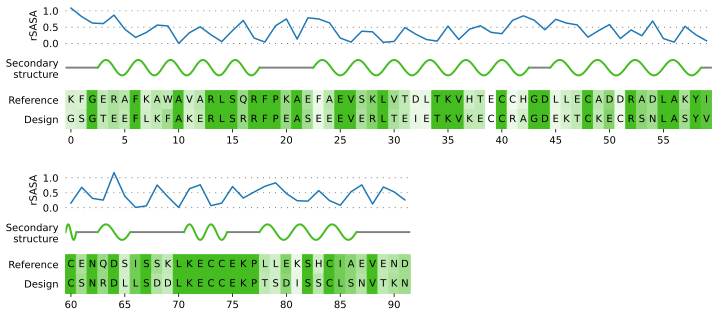

In [37]:
SVG(NOTEBOOK_PATH.joinpath(f"pairwise-alignment-wprops-{domain_id}.svg"))

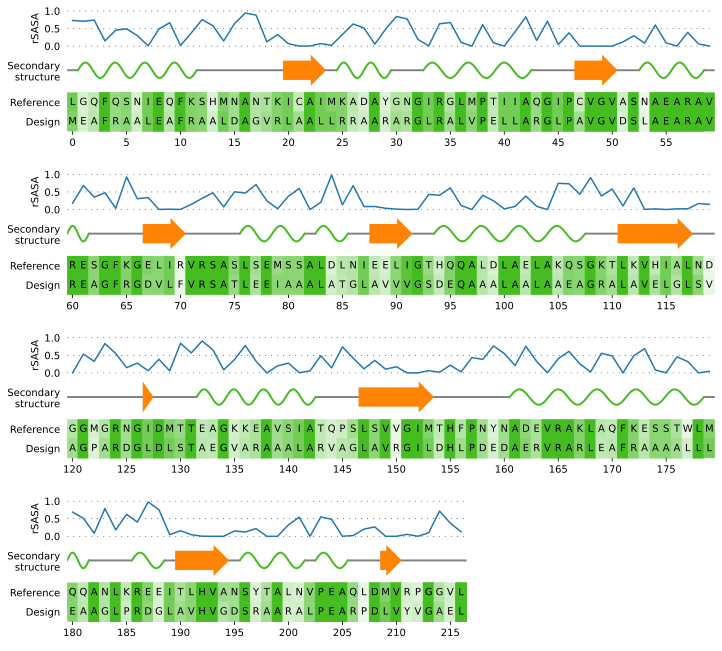

In [38]:
domain_id = "4beuA02"
design_id = "4beu_DopeHD"
symbols_per_line = 60

plot_properties = list(get_plot_properties(domain_id, design_id, symbols_per_line=symbols_per_line))
fg, axs = create_sequence_alignment_plot(plot_properties, symbols_per_line)

fg.savefig(NOTEBOOK_PATH.joinpath(f"pairwise-alignment-wprops-{domain_id}.svg"))
fg.savefig(NOTEBOOK_PATH.joinpath(f"pairwise-alignment-wprops-{domain_id}.pdf"))
fg.savefig(NOTEBOOK_PATH.joinpath(f"pairwise-alignment-wprops-{domain_id}.png"), dpi=300)

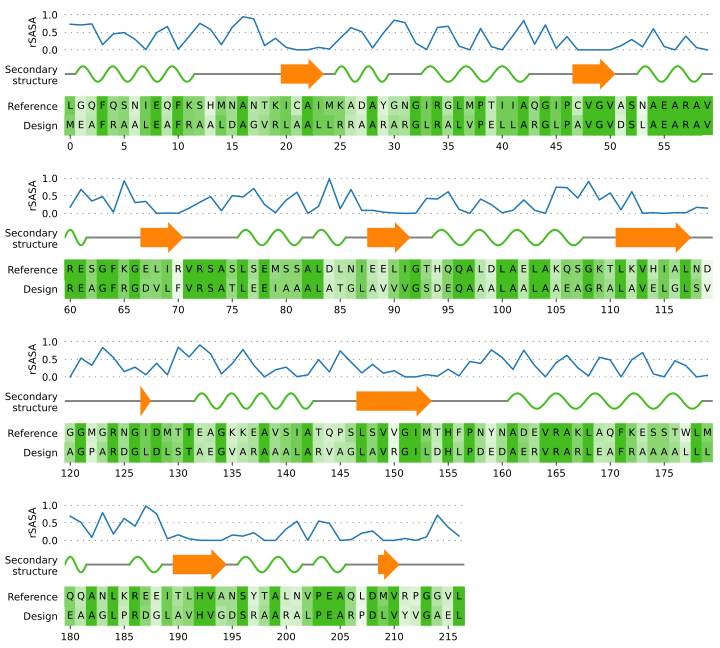

In [39]:
SVG(NOTEBOOK_PATH.joinpath(f"pairwise-alignment-wprops-{domain_id}.svg"))

### Find homologs in training dataset

In [20]:
def calculate_sequence_identity(row):
    sequence_ref = domain_id_to_sequence[row.domain_id]
    assert len(sequence_ref) == len(row.sequence), row
    seq_identity = sum((aa1 == aa2) for aa1, aa2 in zip(row.sequence, sequence_ref)) / len(
        sequence_ref
    )
    return seq_identity

In [21]:
designs_df["seq_identity"] = [calculate_sequence_identity(row) for row in designs_df.itertuples()]

In [22]:
designs_df

,filename,domain_id,selection_method,score,sequence,seq_identity
0,1n5u_DopeNormalized.pdb,1n5uA03,DopeNormalized,10,GSGTEEFLKFAKERLSRRFPEASEEEVERLTEIETKVKECCRAGDE...,0.423913
1,4beu_DopeHD.pdb,4beuA02,DopeHD,7,MEAFRAALEAFRAALDAGVRLAALLRRAARARGLRALVPELLARGL...,0.377880
4,4beu_Comments.pdb,4beuA02,Comments,4,MEAFRAALEAFRAALDAEVRLAALLRRAARARGLRALVPELLARGL...,0.373272
2,4unu_Rosetta.pdb,4unuA00,Rosetta,0,MAFTHPAAATATPGGTVRVACTGDKETVADRPDITWHLRRAGRAVV...,0.357798
5,4unu_Comments.pdb,4unuA00,Comments,0,AAFTHPATATATPGGTVRVACTGDRETVADRPDITWHLRRAGRAVT...,0.357798
7,4unu_FilteredRosetta.pdb,4unuA00,FilteredRosetta,0,SAFTHPAAATARPGGTVRVACTGDKETVADRPDITWHLRRAGRAVT...,0.366972
8,4unu_FilteredMolPDF3.pdb,4unuA00,FilteredMolPDF3,0,MPFTHPASATARPGGTVRVACRGDRETVADRPDITWHLRRAGRAVT...,0.348624
3,4z8j_DopeHD.pdb,4z8jA00,DopeHD,0,MPYKVTFEKADDGFGFDVVGFAEKGGEKVDIKGEKWEPVVTVTSVK...,0.385417
6,4z8j_Comments.pdb,4z8jA00,Comments,4,MPYKVTFEKADDGFGFDVVGFAEKGGEKVDIKGKKWEPVVTVKSVK...,0.375000
9,4z8j_FilteredDopeNormalized.pdb,4z8jA00,FilteredDopeNormalized,0,MPYKVTFEKTDDGFGFDVVGFKEKGGEKVDIKGKKWEPVVTVKSVK...,0.375000


In [23]:
amino_acids = "GVALICMFWPDESTYQNKRH"

In [24]:
output_filename = DATAPKG_DATA_DIR.joinpath(
    "deep-protein-gen", "mmseqs2", "training_data_v2.fasta.gz"
)
output_filename.parent.mkdir(exist_ok=True)

with gzip.open(output_filename, "wb") as fout:
    num_rows = 0
    num_rows_final = 0
    for i in range(10):
        filename = DATAPKG_DATA_DIR.joinpath("deep-protein-gen", f"training_data_rs{i}.parquet")
        pq_file = pq.ParquetFile(filename)
        for row_group in tqdm(range(pq_file.num_row_groups), desc=f"{i}", leave=True):
            df = pq_file.read_row_group(
                row_group, columns=["uniparc_id", "database_id", "structure_id", "sequence"]
            ).to_pandas()
            num_rows += len(df)
            df = df[df["sequence"].str.strip(amino_acids).str.len() == 0]
            num_rows_final += len(df)
            for row in df.itertuples():
                fout.write(
                    f">{row.uniparc_id}|{row.database_id}|{row.structure_id}\n{row.sequence}\n".encode(
                        "utf-8"
                    )
                )
        print(
            f"Lost {num_rows - num_rows_final} rows ({(num_rows - num_rows_final) / num_rows:%})."
        )

FileNotFoundError: [Errno 2] No such file or directory: '/home/strokach/datapkg_data_dir/deep-protein-gen/mmseqs2'

In [ ]:
row = designs_df.iloc[1]
row

In [ ]:
target_db = "/home/kimlab1/database_data/datapkg_output_dir/deep-protein-gen/mmseqs2/training_data_v2"

target_db

In [ ]:
with contextlib.ExitStack() as stack:
    temp_dir = stack.enter_context(tempfile.TemporaryDirectory())
    in_file = stack.enter_context(tempfile.NamedTemporaryFile(suffix=".fasta"))
    out_file = stack.enter_context(tempfile.NamedTemporaryFile(suffix=".m8"))

    with open(in_file.name, "wt") as fout:
        fout.write(f">{row.filename}|{row.domain_id}\n{row.sequence}\n")

    system_command = (
        f"mmseqs easy-search '{in_file.name}' '{target_db}' '{out_file.name}' '{temp_dir}' "
        "-s 7.5 -e 10000 --max-seqs 10000000 --alignment-mode 3 --rescore-mode 3"
    )
    print(system_command)

    cp = subprocess.run(
        shlex.split(system_command), stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True
    )

    with open(out_file.name, "rt") as fin:
        results = fin.read()

In [ ]:
print(cp.stdout)

In [ ]:
row

In [ ]:
with NOTEBOOK_PATH.joinpath("4beu_DopeHD.pdb.m8").open("wt") as fout:
    fout.write(results)

In [ ]:
row

In [ ]:
!ls {NOTEBOOK_PATH}

In [ ]:
!cat {NOTEBOOK_PATH}/4beu_DopeHD.pdb.m8


In [ ]:
print(results)

In [ ]:
with tempfile.NamedTemporaryFile() as in_file, tempfile.NamedTemporaryFile() as out_file:
    with open(in_file.name, "wt") as fout:
        fout.write(f">{row.filename}|{row.domain_id}\n{row.sequence}\n")

    system_command = f"mmseqs easy-search '{in_file.name}' '{target_fasta_file}' '{out_file.name}' --alignment-mode 3"
    cp = subprocess.run(
        shlex.split(system_command), stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True
    )

system_command_template

In [ ]:
DATAPKG_DATA_DIR